In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from capsules_utils.layers import PrimaryCaps, SemanticCaps, FFDecoder

In [2]:
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [0]:
class CapsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9)
        self.primary_caps = PrimaryCaps(n_capsules=32, in_channels=256,
                                        capsule_dimension=8, kernel=9, stride=1)
        self.digit_caps = SemanticCaps(n_capsules=10, n_prev_capsules=32, capsule_dimension=16,
                                       input_size=12*12*8, routing_iterations=3,
                                       gpu=TRAIN_ON_GPU)
        self.decoder = FFDecoder(layers=[512,1024], output_size=(1, 28, 28),
                             input_size=(10, 16), gpu=TRAIN_ON_GPU)

    def forward(self, x, y=None, reconstruction=True):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        x = self.digit_caps(x)

        # calculate norms over the feature dimension
        # dims: (batch, capsules)
        norms = (x ** 2).sum(dim=-1) ** 0.5

        if not reconstruction:
            return norms

        ## create mask for decoder
        one_hot_preds = torch.zeros_like(norms)
        # insert 1 in place of biggest norm per batch
        if y is None:
          # get indices of capsules with biggest norms per batch
          y = norms.argmax(dim=-1)

        one_hot_preds[range(x.size(0)), y] = 1

        if TRAIN_ON_GPU:
            one_hot_preds = one_hot_preds.cuda()

        x = x * one_hot_preds[..., None]

        r = self.decoder(x)

        return r, norms

In [0]:
def margin_loss(norms, labels, m_plus=0.9, m_minus=0.1, lmbda=0.5):
    # transform to one hot encoding
    oh_labels = torch.zeros_like(norms)
    oh_labels[range(norms.size(0)), labels] = 1 

    present = F.relu(m_plus - norms) ** 2
    absent = F.relu(norms - m_minus) ** 2
    loss = oh_labels * present + lmbda * (1. - oh_labels) * absent

    return loss.sum()

def reconstruction_loss(reconstruction, groundtruth):
    return nn.MSELoss(reduction='sum')(reconstruction, groundtruth)

def capsnet_loss(norms, reconstructions, labels, images,
                 m_plus=0.9, m_minus=0.1, margin_c=0.5, rec_c=0.0005):
  # avg over batch  
    return (margin_loss(norms, labels, m_plus, m_minus, margin_c) + \
            rec_c * reconstruction_loss(reconstructions, images)) / norms.size(0)

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to Tensors
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
import time

def train(net, epochs, report=30):
    net.train()

    optimizer = optim.Adam(net.parameters())

    train_history = []
    for epoch in range(epochs):
        t0 = time.time()
        print(f'Epoch {epoch+1}')
        epoch_loss = torch.tensor(0.)
        for batch, (X_batch, y_batch) in enumerate(train_loader):
            if TRAIN_ON_GPU:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            reconstructions, norms = net(X_batch, y_batch)
            loss = capsnet_loss(norms=norms, reconstructions=reconstructions,
                                labels=y_batch, images=X_batch)
            epoch_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if not (batch + 1) % report:
                print(f'\tBatch {batch}\n\t\tTraining Loss: {epoch_loss.item():.3f}\n\t\tTime: {time.time()-t0:.3f}s')
                train_history.append(epoch_loss.item())
                epoch_loss = torch.tensor(0.)
                t0 = time.time()

In [7]:
net = CapsNet()
if TRAIN_ON_GPU:
    net = net.cuda()
train(net, 5, report=460)

Epoch 1
	Batch 459
		Training Loss: 39.952
		Time: 43.260s
	Batch 919
		Training Loss: 17.850
		Time: 44.406s
Epoch 2
	Batch 459
		Training Loss: 14.820
		Time: 46.033s
	Batch 919
		Training Loss: 13.648
		Time: 45.354s
Epoch 3
	Batch 459
		Training Loss: 12.342
		Time: 45.680s
	Batch 919
		Training Loss: 11.536
		Time: 45.507s
Epoch 4
	Batch 459
		Training Loss: 10.888
		Time: 45.483s
	Batch 919
		Training Loss: 10.080
		Time: 45.568s
Epoch 5
	Batch 459
		Training Loss: 9.668
		Time: 45.499s
	Batch 919
		Training Loss: 8.837
		Time: 45.539s


In [0]:
for X_batch, y_batch in test_loader:
    if TRAIN_ON_GPU:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    reconstruction, norms = net(X_batch)
    break

In [0]:
if TRAIN_ON_GPU:
    norms, X_batch, y_batch, reconstruction = norms.detach().cpu(), X_batch.cpu(), y_batch.cpu(), reconstruction.detach().cpu()

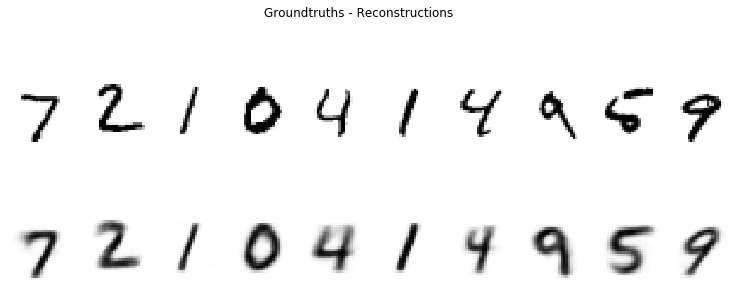

In [10]:
fg, axs = plt.subplots(nrows=2, ncols=10, gridspec_kw={'hspace': 0, 'wspace': 0.1}, figsize=(13,5))
fg.suptitle('Groundtruths - Reconstructions')

for i in range(10):
    axs[0, i].imshow(X_batch[i].squeeze(), cmap='binary')
    axs[1, i].imshow(reconstruction[i].squeeze(), cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [0]:
def test(net):
    net.eval()
    evals = torch.empty(len(test_data))

    for batch, (X_batch, y_batch) in enumerate(test_loader):
        if TRAIN_ON_GPU:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        norms = net(X_batch, reconstruction=False)
        preds = norms.argmax(dim=-1)
        try:
            evals[batch * batch_size : (batch+1) * batch_size] = (preds == y_batch)
        except IndexError:
            evals[batch * batch_size:] = (preds == y_batch)
    return evals.mean().item()

In [12]:
print(f'CapsNet Accuracy: {test(net)*100:.2f}%')

CapsNet Accuracy: 98.78%
